# JuzData: proceso de generacion de causas - analisis temporal

En el presente notebook se analiza la columna 'exp_fechecho' de nuestro dataset, que contiene las fechas de los hechos que motivaron las causas judiciales. En consecuencia no vamos a meternos con el proceso de distribucion de causas, sino unicamente con su generacion; en particular, me interesa analizar si existe estacionalidad y autocorrelacion temporal en el proceso.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calmap
import warnings
warnings.filterwarnings('ignore')

In [42]:
df = pd.read_excel('penal_df_fec.xlsx')

In [45]:
df['exp_fechecho_dt'] = pd.to_datetime(df['exp_fechecho_dt'])
df[['exp_fechecho','exp_fechecho_dt']].head(10)

,exp_fechecho,exp_fechecho_dt
0,17/2/2014 00:00,2014-02-17
1,NaN,NaT
2,2014-03-12 00:00:00,2014-03-12
3,13/4/2015 00:00,2015-04-13
4,14/5/2015 00:00,2015-05-14
5,2015-01-08 00:00:00,2015-01-08
6,NaN,NaT
7,15/7/2015 00:00,2015-07-15
8,14/5/2015 00:00,2015-05-14
9,NaN,NaT


In [46]:
# convierto 'unknown' en NaN para contabilizar
import itertools as it
for i, col in it.product(df.index,df.columns):
    if df.at[i,col] == 'unknown':
        df.at[i,col] = np.nan

In [47]:
df['exp_fechecho_dt'].notna().sum()

13163

In [48]:
calendar = df['exp_fechecho_dt'].value_counts()
calendar.head()

2017-01-01    42
2016-12-02    32
2016-01-13    30
2016-04-14    30
2016-09-22    29
Name: exp_fechecho_dt, dtype: int64

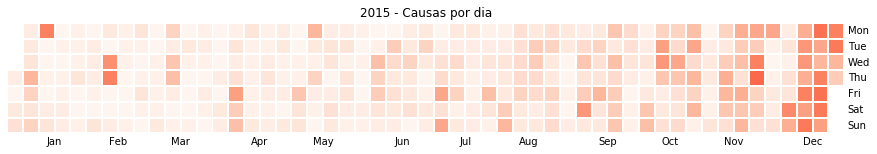

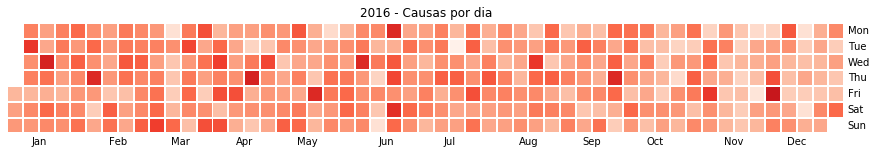

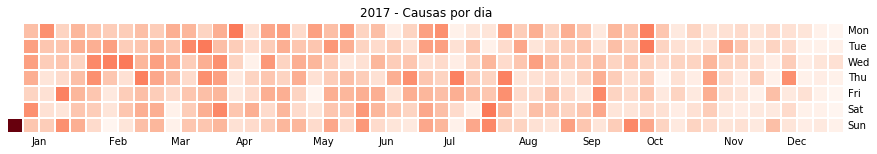

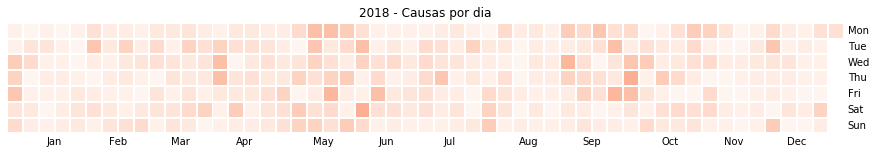

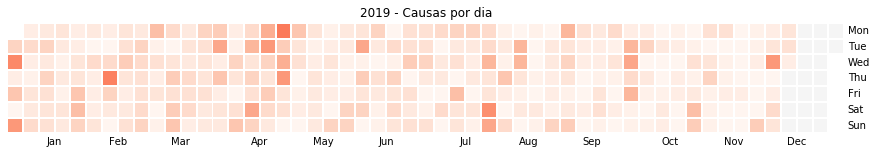

In [189]:
years = [2015,2016,2017,2018,2019]
for year in years:
    plt.figure(figsize=(15,10))
    calmap.yearplot(calendar, year=year)
    plt.title(str(year) + ' - Causas por dia')
    file_name = 'calendar_heatmap_'+str(year)+'.png'
    plt.savefig(file_name)
    plt.show()

Que se puede ver en estos heatmaps: no parece haber una marcada estacionalidad (ver analisis mas abajo); el año 2016 presenta muchas mas causas que los demas (ver detalle abajo); y, lo que es mas importante a nuestros fines, se registra una tendencia a la autocorrelacion temporal de la cantidad de causas. Esto significa que los hechos que dan lugar a causas se agrupan en clusters temporales (como ya vimos que lo hacen geograficamente).

## Analisis por año

In [115]:
df_year_groupby = df.groupby(df['exp_fechecho_dt'].dt.year)
df_year_count = df_year_groupby.count()['exp_cuij'].to_frame(name='causas')
df_year_count

,causas
exp_fechecho_dt,
1969.0,32
2006.0,1
2007.0,1
2008.0,2
2009.0,2
2010.0,4
2011.0,1
2012.0,16
2013.0,66


In [126]:
df_year_count.index = df_year_count.index.astype(str)

In [134]:
calendar_level = pd.DataFrame()
for i,index in enumerate(calendar.index):
    calendar_level.at[i,'fecha'] = index
    calendar_level.at[i,'causas'] = calendar[index]
    # llevamos el año al type de df_year_count
    year = str(index.year)
    causas_year = df_year_count.at[year,'causas']
    calendar_level.at[i,'causas-level'] = calendar[index] / causas_year

In [135]:
calendar_level.head()

,fecha,causas,causas-level
0,2017-01-01,42.0,0.013935
1,2016-12-02,32.0,0.005670
2,2016-01-13,30.0,0.005315
3,2016-04-14,30.0,0.005315
4,2016-09-22,29.0,0.005138


In [165]:
calendar_level['fecha'] = pd.to_datetime(calendar_level['fecha'])

In [174]:
calendar_level_series = pd.Series(data=calendar_level['causas-level'].values,
                                  index=calendar_level['fecha'])

In [172]:
calendar_level_series

fecha
2017-01-01 00:00:00    139.349701
2016-12-02 00:00:00     56.697378
2016-01-13 00:00:00     53.153792
2016-04-14 00:00:00     53.153792
2016-09-22 00:00:00     51.381999
                          ...    
2017-10-28 18:15:00      3.317850
2019-09-28 14:00:00      7.380074
2018-06-14 20:00:00      8.130081
2018-05-10 00:00:00      8.130081
2019-02-04 00:00:00      7.380074
Length: 3156, dtype: float64

## Causas por meses (estacionalidad)

In [175]:
df_month_groupby = df.groupby(df['exp_fechecho_dt'].dt.month)
df_month_count = df_month_groupby.count()['exp_cuij'].to_frame(name='causas')
df_month_count

,causas
exp_fechecho_dt,
1.0,1184
2.0,1056
3.0,1154
4.0,1152
5.0,1160
6.0,1132
7.0,1111
8.0,1083
9.0,1115


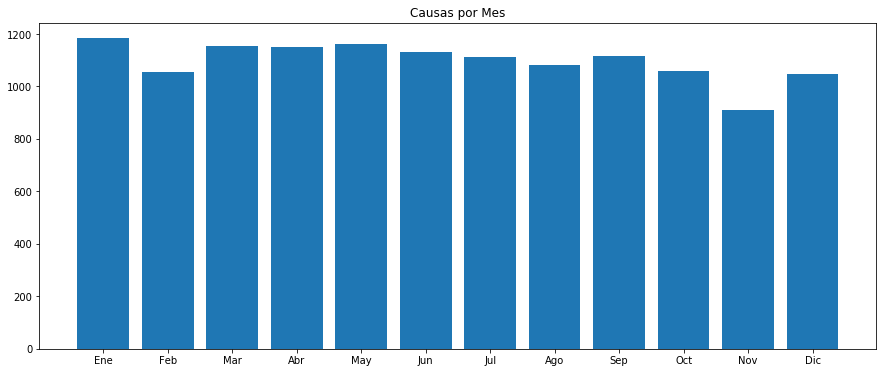

In [187]:
meses = ['Ene','Feb','Mar','Abr','May','Jun',
         'Jul','Ago','Sep','Oct','Nov','Dic']
plt.figure(figsize=(15,6))
plt.bar(x=meses,
        height=df_month_count.values.flatten())
plt.title('Causas por Mes')
plt.savefig('causas_por_mes.png')
plt.show()

No parece haber fuerte estacionalidad (faltaria un test formal).

## Expedientes

In [190]:
# separo exp_cuij en tres columnas
for i in df.index:
    df.at[i,'exp_cuij_1'] = df.at[i,'exp_cuij'][0:2]
    df.at[i,'exp_cuij_2'] = df.at[i,'exp_cuij'][3:11]
    df.at[i,'exp_cuij_3'] = df.at[i,'exp_cuij'][12:13]

In [31]:
df.shape

(37136, 62)

In [30]:
# expedientes unicos segun exp_cuij
df['exp_cuij_2'].unique().shape

(28258,)

In [188]:
# expedientes unicos segun exp_id
df['exp_id'].unique().shape

(32384,)